## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
print(tf.__version__)

2.3.0


## Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

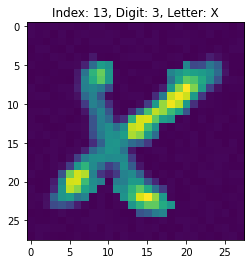

In [29]:
idx = 13
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [5]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [6]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [7]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


---

In [8]:
x_train1 = np.repeat(x_train, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_edit1=np.repeat(x_edit, 3, axis=1)
x_edit2=np.repeat(x_edit1, 3, axis=2)

In [9]:
print(x_train2.shape, x_edit2.shape)

(2048, 84, 84, 1) (2048, 84, 84, 1)


In [10]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [53]:
# 초반 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=100

#model.fit(x_train, y_train, epochs=50)
history = model.fit(
  datagen.flow(x_edit2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_edit2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/100
128/128 [==============================] - 3s 23ms/step - loss: 3.8072 - accuracy: 0.3032
Epoch 2/100
128/128 [==============================] - 3s 22ms/step - loss: 2.6466 - accuracy: 0.3818
Epoch 3/100
128/128 [==============================] - 3s 23ms/step - loss: 2.4681 - accuracy: 0.4038
Epoch 4/100
128/128 [==============================] - 3s 22ms/step - loss: 2.2732 - accuracy: 0.4551
Epoch 5/100
128/128 [==============================] - 3s 22ms/step - loss: 2.2523 - accuracy: 0.4521
Epoch 6/100
128/128 [==============================] - 3s 22ms/step - loss: 2.1802 - accuracy: 0.4521
Epoch 7/100
128/128 [==============================] - 3s 23ms/step - loss: 2.1223 - accuracy: 0.4756
Epoch 8/100
128/128 [==============================] - 3s 22ms/step - loss: 2.0259 - accuracy: 0.5054
Epoch 9/100
128/128 [==============================] - 3s 23ms/step - loss: 1.9499 - accuracy: 0.5093
Epoch 10/100
128/128 [==============================] - 3s 23ms/step - loss: 1.877

128/128 [==============================] - 3s 20ms/step - loss: 0.6280 - accuracy: 0.8638
Epoch 81/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6414 - accuracy: 0.8506
Epoch 82/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6309 - accuracy: 0.8633
Epoch 83/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6037 - accuracy: 0.8779
Epoch 84/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6242 - accuracy: 0.8667
Epoch 85/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6011 - accuracy: 0.8770
Epoch 86/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6166 - accuracy: 0.8706
Epoch 87/100
128/128 [==============================] - 3s 20ms/step - loss: 0.5951 - accuracy: 0.8667
Epoch 88/100
128/128 [==============================] - 3s 20ms/step - loss: 0.5809 - accuracy: 0.8774
Epoch 89/100
128/128 [==============================] - 3s 20ms/step - loss: 0.6146 - 

In [54]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model() #앞에거에 이어서 학습
epochs=80

#model.fit(x_train, y_train, epochs=50)
for i in range(0,10):
    history = model.fit(
      datagen.flow(x_train2, y_train, batch_size=32),
      epochs=epochs, 
      steps_per_epoch = x_train2.shape[0]//32,
      callbacks=[annealer], 
      verbose = 1)

Epoch 1/80
64/64 [==============================] - 2s 33ms/step - loss: 1.4061 - accuracy: 0.6055
Epoch 2/80
64/64 [==============================] - 2s 33ms/step - loss: 0.9861 - accuracy: 0.7378
Epoch 3/80
64/64 [==============================] - 2s 33ms/step - loss: 0.8167 - accuracy: 0.8008
Epoch 4/80
64/64 [==============================] - 2s 33ms/step - loss: 0.6867 - accuracy: 0.8467
Epoch 5/80
64/64 [==============================] - 2s 33ms/step - loss: 0.6496 - accuracy: 0.8481
Epoch 6/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5858 - accuracy: 0.8696
Epoch 7/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5331 - accuracy: 0.8877
Epoch 8/80
64/64 [==============================] - 2s 33ms/step - loss: 0.4800 - accuracy: 0.9087
Epoch 9/80
64/64 [==============================] - 2s 33ms/step - loss: 0.4749 - accuracy: 0.9043
Epoch 10/80
64/64 [==============================] - 2s 33ms/step - loss: 0.4499 - accuracy: 0.9067
Epoch 11/

64/64 [==============================] - 2s 33ms/step - loss: 0.0894 - accuracy: 0.9976
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 1.1303 - accuracy: 0.7324
Epoch 2/80
64/64 [==============================] - 2s 33ms/step - loss: 1.1384 - accuracy: 0.7422
Epoch 3/80
64/64 [==============================] - 2s 36ms/step - loss: 0.8553 - accuracy: 0.8154
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.6731 - accuracy: 0.8604
Epoch 5/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5449 - accuracy: 0.8867
Epoch 6/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5031 - accuracy: 0.9014
Epoch 7/80
64/64 [==============================] - 2s 34ms/step - loss: 0.4438 - accuracy: 0.9131
Epoch 8/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3902 - accuracy: 0.9268
Epoch 9/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3742 - accuracy: 0.9297
Epoch 10/80
64/64 [==

64/64 [==============================] - 2s 33ms/step - loss: 0.0512 - accuracy: 0.9956
Epoch 80/80
64/64 [==============================] - 2s 33ms/step - loss: 0.0486 - accuracy: 0.9971
Epoch 1/80
64/64 [==============================] - 2s 33ms/step - loss: 0.7882 - accuracy: 0.8105
Epoch 2/80
64/64 [==============================] - 2s 33ms/step - loss: 0.9003 - accuracy: 0.8145
Epoch 3/80
64/64 [==============================] - 2s 33ms/step - loss: 0.6259 - accuracy: 0.8711
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.5779 - accuracy: 0.8906
Epoch 5/80
64/64 [==============================] - 2s 36ms/step - loss: 0.4920 - accuracy: 0.9087
Epoch 6/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3997 - accuracy: 0.9409
Epoch 7/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3634 - accuracy: 0.9355
Epoch 8/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3223 - accuracy: 0.9468
Epoch 9/80
64/64 [==

64/64 [==============================] - 2s 33ms/step - loss: 0.0598 - accuracy: 0.9961
Epoch 79/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0555 - accuracy: 0.9976
Epoch 80/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0561 - accuracy: 0.9961
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 0.5374 - accuracy: 0.8740
Epoch 2/80
64/64 [==============================] - 2s 33ms/step - loss: 0.6929 - accuracy: 0.8633
Epoch 3/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5669 - accuracy: 0.9014
Epoch 4/80
64/64 [==============================] - 2s 33ms/step - loss: 0.4697 - accuracy: 0.9248
Epoch 5/80
64/64 [==============================] - 2s 34ms/step - loss: 0.4220 - accuracy: 0.9297
Epoch 6/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3567 - accuracy: 0.9424
Epoch 7/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3759 - accuracy: 0.9312
Epoch 8/80
64/64 [=

64/64 [==============================] - 2s 33ms/step - loss: 0.0518 - accuracy: 0.9946
Epoch 78/80
64/64 [==============================] - 2s 33ms/step - loss: 0.0511 - accuracy: 0.9971
Epoch 79/80
64/64 [==============================] - 2s 35ms/step - loss: 0.0506 - accuracy: 0.9946
Epoch 80/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0502 - accuracy: 0.9980
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 0.1878 - accuracy: 0.9526
Epoch 2/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5954 - accuracy: 0.8691
Epoch 3/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5219 - accuracy: 0.8945
Epoch 4/80
64/64 [==============================] - 2s 33ms/step - loss: 0.4041 - accuracy: 0.9312
Epoch 5/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3538 - accuracy: 0.9463
Epoch 6/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3292 - accuracy: 0.9414
Epoch 7/80
64/64 [

64/64 [==============================] - 2s 33ms/step - loss: 0.0840 - accuracy: 0.9971
Epoch 77/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0819 - accuracy: 0.9971
Epoch 78/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0835 - accuracy: 0.9961
Epoch 79/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0861 - accuracy: 0.9941
Epoch 80/80
64/64 [==============================] - 2s 33ms/step - loss: 0.0830 - accuracy: 0.9951
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3263 - accuracy: 0.9277
Epoch 2/80
64/64 [==============================] - 2s 34ms/step - loss: 0.5463 - accuracy: 0.8965
Epoch 3/80
64/64 [==============================] - 2s 34ms/step - loss: 0.4613 - accuracy: 0.9248
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.4425 - accuracy: 0.9224
Epoch 5/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3624 - accuracy: 0.9487
Epoch 6/80
64/64 

64/64 [==============================] - 2s 33ms/step - loss: 0.0577 - accuracy: 0.9966
Epoch 76/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0599 - accuracy: 0.9961
Epoch 77/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0609 - accuracy: 0.9956
Epoch 78/80
64/64 [==============================] - 2s 33ms/step - loss: 0.0580 - accuracy: 0.9971
Epoch 79/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0625 - accuracy: 0.9946
Epoch 80/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0542 - accuracy: 0.9961
Epoch 1/80
64/64 [==============================] - 2s 33ms/step - loss: 0.3041 - accuracy: 0.9258
Epoch 2/80
64/64 [==============================] - 2s 33ms/step - loss: 0.5545 - accuracy: 0.9048
Epoch 3/80
64/64 [==============================] - 2s 34ms/step - loss: 0.5425 - accuracy: 0.9004
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3695 - accuracy: 0.9531
Epoch 5/80
64/64

64/64 [==============================] - 2s 33ms/step - loss: 0.0455 - accuracy: 0.9971
Epoch 78/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0476 - accuracy: 0.9966
Epoch 79/80
64/64 [==============================] - 2s 33ms/step - loss: 0.0482 - accuracy: 0.9956
Epoch 80/80
64/64 [==============================] - 2s 35ms/step - loss: 0.0480 - accuracy: 0.9980
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3432 - accuracy: 0.9292
Epoch 2/80
64/64 [==============================] - 2s 35ms/step - loss: 0.8325 - accuracy: 0.8501
Epoch 3/80
64/64 [==============================] - 2s 34ms/step - loss: 1.0079 - accuracy: 0.8530
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.9780 - accuracy: 0.8799
Epoch 5/80
64/64 [==============================] - 2s 33ms/step - loss: 0.6704 - accuracy: 0.9517
Epoch 6/80
64/64 [==============================] - 2s 34ms/step - loss: 0.5840 - accuracy: 0.9580
Epoch 7/80
64/64 [

64/64 [==============================] - 2s 34ms/step - loss: 0.0925 - accuracy: 0.9956
Epoch 80/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0905 - accuracy: 0.9976
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3228 - accuracy: 0.9380
Epoch 2/80
64/64 [==============================] - 2s 35ms/step - loss: 0.5727 - accuracy: 0.9058
Epoch 3/80
64/64 [==============================] - 2s 34ms/step - loss: 0.5814 - accuracy: 0.9160
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.4348 - accuracy: 0.9546
Epoch 5/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3617 - accuracy: 0.9663
Epoch 6/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3084 - accuracy: 0.9712
Epoch 7/80
64/64 [==============================] - 2s 34ms/step - loss: 0.2699 - accuracy: 0.9775
Epoch 8/80
64/64 [==============================] - 2s 34ms/step - loss: 0.2445 - accuracy: 0.9731
Epoch 9/80
64/64 [==

64/64 [==============================] - 2s 34ms/step - loss: 0.0576 - accuracy: 0.9956
Epoch 79/80
64/64 [==============================] - 2s 33ms/step - loss: 0.0525 - accuracy: 0.9971
Epoch 80/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0581 - accuracy: 0.9951
Epoch 1/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3393 - accuracy: 0.9336
Epoch 2/80
64/64 [==============================] - 2s 34ms/step - loss: 0.6846 - accuracy: 0.8931
Epoch 3/80
64/64 [==============================] - 2s 35ms/step - loss: 0.5267 - accuracy: 0.9341
Epoch 4/80
64/64 [==============================] - 2s 34ms/step - loss: 0.4030 - accuracy: 0.9590
Epoch 5/80
64/64 [==============================] - 2s 34ms/step - loss: 0.3410 - accuracy: 0.9683
Epoch 6/80
64/64 [==============================] - 2s 36ms/step - loss: 0.2910 - accuracy: 0.9746
Epoch 7/80
64/64 [==============================] - 2s 34ms/step - loss: 0.2601 - accuracy: 0.9795
Epoch 8/80
64/64 [=

64/64 [==============================] - 2s 34ms/step - loss: 0.0518 - accuracy: 0.9971
Epoch 78/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0496 - accuracy: 0.9951
Epoch 79/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0478 - accuracy: 0.9961
Epoch 80/80
64/64 [==============================] - 2s 34ms/step - loss: 0.0513 - accuracy: 0.9951


## Predict

In [55]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [56]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [57]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [58]:
submission.to_csv('앞단 100 뒷단 80으로 10번.csv', index=False)

---

In [81]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [82]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [83]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,2
3,2052,8
4,2053,8
5,2054,8
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [84]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('두번 이어서 훈련_이진화otest.csv', index=False)